In [2]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, LSTM, Dropout

Using TensorFlow backend.


## 1st Dataset

In [3]:
df = pd.read_csv('data_train_3.csv', sep='\t', header=None, names=['id', 'label', 'tweet'])\
    .set_index('id')

In [4]:
def tokenize(values):
    tokenizer = Tokenizer(num_words=2500, lower=True, split=' ')
    tokenizer.fit_on_texts(values)
    return tokenizer

def preprocessing(tokenizer, values):
    X = tokenizer.texts_to_sequences(values)
    X = pad_sequences(X, maxlen=50)
    return X

In [5]:
tokenizer = tokenize(df.tweet.values)

In [6]:
X = preprocessing(tokenizer, df.tweet.values)

In [7]:
embed_dim = 128
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(Embedding(2500, embed_dim, input_length = X.shape[1], dropout = 0.2))
model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/Users/paulvilledieu/SCIA/Introduction-DeepLearning/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  
/Users/paulvilledieu/SCIA/Introduction-DeepLearning/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 128)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 603       
Total params: 583,803
Trainable params: 583,803
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
Y = pd.get_dummies(df['label']).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.20, random_state = 36)

#Here we train the Network.

history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size =batch_size, nb_epoch = 2)

Instructions for updating:
Use tf.cast instead.


/Users/paulvilledieu/SCIA/Introduction-DeepLearning/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 40266 samples, validate on 10067 samples
Epoch 1/2
40266/40266 [==============================] - 65s 2ms/step - loss: 0.8431 - acc: 0.6039 - val_loss: 0.7726 - val_acc: 0.6487
Epoch 2/2
40266/40266 [==============================] - 68s 2ms/step - loss: 0.7386 - acc: 0.6675 - val_loss: 0.7615 - val_acc: 0.6548


In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<Figure size 400x400 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [10]:
base_model = model

## 2nd Dataset

In [11]:
df = pd.read_csv('2018-Valence-oc-En-train.txt', sep='\t')\
    .rename(columns={"ID": "id", "Tweet": "tweet", "Affect Dimension": "dim", "Intensity Class": "label"})\
    .set_index('id')\
    .drop(columns=['dim'])

In [12]:
df.label = df.label.apply(lambda x: x.split(':')[0])

In [13]:
X = preprocessing(tokenizer, df.tweet.values)

In [14]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = model.layers[-2].output
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=7)

In [15]:
finetune_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1_input (InputLaye (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 128)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              205824    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
__________

In [16]:
finetune_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [17]:
Y = pd.get_dummies(df['label']).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.20, random_state = 36)

#Here we train the Network.

history = finetune_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size =batch_size, nb_epoch = 2)

/Users/paulvilledieu/SCIA/Introduction-DeepLearning/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 944 samples, validate on 237 samples
Epoch 1/2
944/944 [==============================] - 2s 2ms/step - loss: 1.7305 - acc: 0.3072 - val_loss: 1.6378 - val_acc: 0.3376
Epoch 2/2
944/944 [==============================] - 1s 1ms/step - loss: 1.6520 - acc: 0.3517 - val_loss: 1.6462 - val_acc: 0.3249


In [18]:
score, acc = finetune_model.evaluate(X_valid, Y_valid, batch_size=batch_size)
print(f'Score: {score}')
print(f'Val accuracy: {acc}')

237/237 [==============================] - 0s 423us/step
Score: 1.646172516456636
Val accuracy: 0.32489451539667347


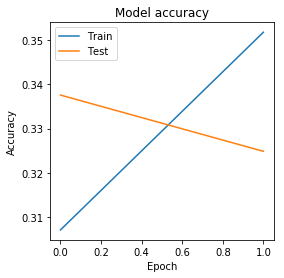

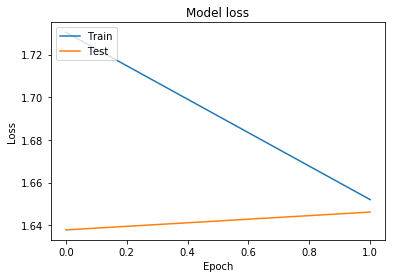

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(4,4))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
df_test = pd.read_csv('2018-Valence-oc-En-dev.txt', sep='\t')\
    .rename(columns={"ID": "id", "Tweet": "tweet", "Affect Dimension": "dim", "Intensity Class": "label"})\
    .set_index('id')\
    .drop(columns=['dim'])

In [21]:
df_test.label = df_test.label.apply(lambda x: x.split(':')[0])

In [22]:
X_test = preprocessing(tokenizer, df_test.tweet.values)

In [23]:
Y_test = pd.get_dummies(df_test['label']).values
Y_pred = finetune_model.predict(X_test)

In [24]:
score, acc = finetune_model.evaluate(X_test, Y_test, batch_size=batch_size)
print(f'Score: {score}')
print(f'Val accuracy: {acc}')

449/449 [==============================] - 0s 386us/step
Score: 1.6972268947248734
Val accuracy: 0.2962138084632517


In [220]:
Y_test

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [230]:
from scipy.stats import pearsonr

def pearson_metric(y_pred, y_test):
    y_pred = np.argmax(y_pred, axis=1) - 3
    y_test = np.argmax(y_test, axis=1) - 3
    return pearsonr(y_test, y_pred)[0]

In [231]:
pearson_metric(Y_pred, Y_test)

0.5168686329996931

In [240]:
from sklearn.metrics import cohen_kappa_score

def kappa_metric(y_pred, y_test):
    y_pred = np.argmax(y_pred, axis=1) - 3
    y_test = np.argmax(y_test, axis=1) - 3
    return cohen_kappa_score(y_pred, y_test)

In [241]:
kappa_metric(Y_pred, Y_test)

0.17686867682517593

In [62]:
df_test2 = pd.read_csv('2018-Valence-oc-En-test.txt', sep='\t')\
      .rename(columns={"ID": "id", "Tweet": "text"})\
#      .set_index('id')\
#      .drop(columns=['dim'])

In [63]:
df_test2.head()

,id,text,Affect Dimension,sentiment
0,2018-En-01964,Gm and have a #Tuesday!,valence,NONE
1,2018-En-01539,@realDonaldTrump But you have a lot of time fo...,valence,NONE
2,2018-En-04235,I graduated yesterday and already had 8 family...,valence,NONE
3,2018-En-03711,@jaimitoelcrack7 Seriously...I've been sitting...,valence,NONE
4,2018-En-01177,Whether my glass is half empty or its half ful...,valence,NONE


In [64]:
X_test = preprocessing(tokenizer, df_test2.text.values)

In [65]:
#Y_test = pd.get_dummies(df_test['label']).values
Y_pred = finetune_model.predict(X_test)

In [66]:
df_test2.sentiment = np.argmax(Y_pred, axis=1) - 3

In [67]:
df_test2

,id,text,Affect Dimension,sentiment
0,2018-En-01964,Gm and have a #Tuesday!,valence,0
1,2018-En-01539,@realDonaldTrump But you have a lot of time fo...,valence,1
2,2018-En-04235,I graduated yesterday and already had 8 family...,valence,-2
3,2018-En-03711,@jaimitoelcrack7 Seriously...I've been sitting...,valence,-2
4,2018-En-01177,Whether my glass is half empty or its half ful...,valence,0
5,2018-En-01352,Do you ever fall asleep before you set your al...,valence,0
6,2018-En-03829,There was a live chicken running around the cf...,valence,0
7,2018-En-02627,Memo to @PutinRF_Eng: I'm going to run for #PO...,valence,0
8,2018-En-02078,@TommySandhu @bbcasiannetwork tommy you r phen...,valence,3
9,2018-En-00030,@LDN_Muscle a #bright and early session this m...,valence,0


In [68]:
def write_tweet_v2(tweet: pd.DataFrame, path: str):
        classes = np.array(['0: neutral or mixed emotional state can be inferred',
                            '1: slightly positive emotional state can be inferred',
                            '2: moderately positive emotional state can be inferred',
                            '3: very positive emotional state can be inferred',
                            '-3: very negative emotional state can be inferred',
                            '-2: moderately negative emotional state can be inferred',
                            '-1: slightly negative emotional state can be inferred'])
        tweet = tweet.copy(deep=True)
        tweet['dim'] = ['valence'] * tweet.shape[0]
        tweet['class'] = classes[tweet['sentiment']]
        tweet = tweet[['id', 'text', 'dim', 'class']]
        tweet.columns = ['ID', 'Tweet', 'Affect Dimension', 'Intensify Class']
        tweet.to_csv(path, sep='\t', index=False)

In [69]:
write_tweet_v2(df_test2, path='../TP1-Paul/results.csv')

In [49]:
results_csv = pd.read_csv('../predict.csv', sep='\t', header=None, names = ['id', 'tweet', 'val', 'label'])
results_csv.label = results_csv.label.apply(lambda x: x.split(':')[0])

In [51]:
results_csv[['tweet', 'label']]

,tweet,label
0,Tweet,Intensify Class
1,Gm and have a #Tuesday!,-3
2,@realDonaldTrump But you have a lot of time fo...,2
3,I graduated yesterday and already had 8 family...,2
4,@jaimitoelcrack7 Seriously...I've been sitting...,0
5,Whether my glass is half empty or its half ful...,0
6,Do you ever fall asleep before you set your al...,-3
7,There was a live chicken running around the cf...,2
8,Memo to @PutinRF_Eng: I'm going to run for #PO...,-3
9,@TommySandhu @bbcasiannetwork tommy you r phen...,0
